In [68]:
import os

import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

In [69]:
A = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, .7, 0, 0], [0, 2, 0, 0]])
B = np.array([0, 0, 1, .5])


def calculate_next_state(state, time_delta, u):
    if callable(u):
        u = u(state)
    return state + time_delta * (A @ state + B * u)


def simulate_states(initial_state, time_end, time_delta=0.01, u=.4):
    time = 0
    current_state = initial_state
    states = {0: initial_state}
    while time <= time_end and abs(current_state[1]) < 1:
        time += time_delta
        current_state = calculate_next_state(current_state, time_delta, u)
        states[time] = current_state
    return states


def visualize_states(states, title="Zustandsverlauf"):
    fig, ax = plt.subplots()
    ax.plot(states.keys(), states.values(), label=["$p$", "$\\theta$", "$\\dot{p}$", "$\\dot{\\theta}$"])
    ax.set_title(title)
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Zustand")
    ax.legend(loc='upper left')


def calculate_positions(states, arm_length=4):
    positions = {}
    for time, state in states.items():
        theta = state[1]
        p = state[0]

        x = p + np.sin(theta) * arm_length
        y = np.cos(theta) * arm_length
        positions[time] = np.array([x, y])
    return positions


def visualize_positions(positions, title="Positionsverlauf"):
    fig, ax = plt.subplots()
    ax.plot(positions.keys(), positions.values(), label=["x", "y"])
    ax.set_title(title)
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Länge")
    ax.legend(loc='upper left')


def calculate_joint_positions(states, arm_length=4):
    positions = {}
    i = 0
    for time, state in states.items():
        theta = state[1]
        p = state[0]
        base = np.array([p, 0])

        arm = base + np.array([np.sin(theta) * arm_length, np.cos(theta) * arm_length])
        positions[i] = np.vstack([base, arm])
        i += 1
    return positions


def animate_joint_positions(positions, interval=0.01, title="Positionsanimation", dpi=150):
    array = np.array(list(positions.values()))
    y_max = np.max(array[:, :, 1])
    y_min = np.min(array[:, :, 1])

    x_max = np.max(array[:, :, 0])
    x_min = np.min(array[:, :, 0])

    def plot_frame(frame):
        position = positions[frame]

        fig, ax = plt.subplots()

        ax.plot(position[:, 0], position[:, 1], "b")
        ax.plot(position[:, 0], position[:, 1], "ro")
        ax.text(0.02, 0.95, f'Zeit $t={frame * interval}$', transform=ax.transAxes)

        ax.set_xlim(x_min - 1, x_max + 1)
        ax.set_ylim(y_min - 1, y_max + 1)
        ax.set_aspect('equal')

        ax.set_title(title)
        ax.set_xlabel("x [m]")
        ax.set_ylabel("y [m]")

        filename = f'build/{title}_{frame}.png'
        fig.savefig(filename, dpi=dpi)
        plt.close(fig)
        return filename

    if not os.path.exists("build/"):
        os.mkdir("build/")

    filenames = [plot_frame(frame) for frame in range(len(positions))]

    gif_filename = f"{title}.gif"

    with imageio.get_writer(gif_filename, mode="I", duration=interval) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    for filename in set(filenames):
        os.remove(filename)

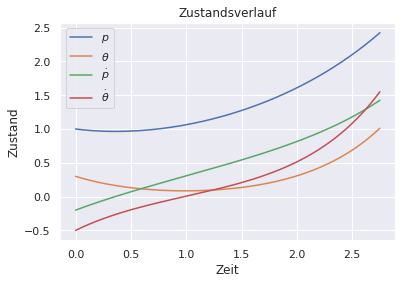

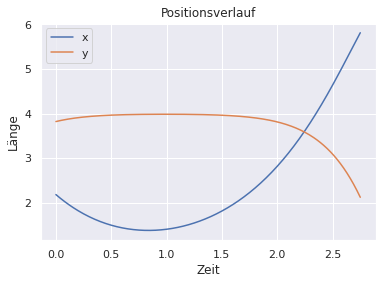

In [70]:
simulation_1 = simulate_states(np.array([1, .3, -.2, -.5]), 100, u=.4)
visualize_states(simulation_1)
visualize_positions(calculate_positions(simulation_1))

#animate_joint_positions(calculate_joint_positions(simulation_1))

In [71]:
C = np.array([[1, 0, 0, 0]])


def animate_matplotlib(draw_fn, frames, interval=0.01, title="Positionsanimation", dpi=150):
    def save_fig(frame):
        fig = draw_fn(frame)
        fig.savefig(f"build/{title}_{frame}", dpi)

    if not os.path.exists("build/"):
        os.mkdir("build/")

    filenames = [save_fig(frame) for frame in range(frames)]

    gif_filename = f"{title}.gif"

    with imageio.get_writer(gif_filename, mode="I", duration=interval) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    for filename in set(filenames):
        os.remove(filename)


def simulate_observer(initial_state, initial_observer_state, time_end, time_delta=0.01, u=.4, k=-1):
    time = 0

    L = np.array([-4 * k,
                  (-8 * k - 4 * (k ** 3)) / 0.7,
                  6 * k ** 2 + 2,
                  ((k ** 4) + 12 * (k ** 2) + 4) / 0.7])

    def calculate_next_state(state, u_value):
        return state + time_delta * (A @ state + B * u_value)

    def calculate_output(state):
        return C @ state

    def calculate_next_observer_state(state, y, u_value):
        return state + time_delta * (A @ state + B * u_value + L * (y - C @ state))

    states = {0: initial_state}
    observer_states = {0: initial_observer_state}

    current_state = initial_state
    current_observer_state = initial_observer_state
    while time <= time_end:
        time += time_delta

        u_value = u(current_observer_state) if callable(u) else u

        current_state = calculate_next_state(current_state, u_value=u_value)
        y = calculate_output(current_state)
        states[time] = current_state

        current_observer_state = calculate_next_observer_state(current_observer_state, y, u_value=u_value)
        observer_states[time] = current_observer_state
    return states, observer_states


def visualize_observer_states(states, observer_states, title="Beobachterzustand vs echter Zustand"):
    fig, axes = plt.subplots(2, 2, figsize=(12, 6.75))

    fig.suptitle(title)

    labels = ["$p$", "$\\theta$", "$\\dot{p}$", "$\\dot{\\theta}$"]
    observer_labels = ["$\\hat{p}$", "$\\hat{\\theta}$", "$\\hat{\\dot{p}}$", "$\\hat{\\dot{\\theta}}$"]

    state_values = np.array(list(states.values()))
    observer_values = np.array(list(observer_states.values()))

    i = 0
    for ax in axes.flat:
        ax.set_title(labels[i])
        ax.plot(states.keys(), state_values[:, i], label=labels[i])
        ax.plot(observer_states.keys(), observer_values[:, i], label=observer_labels[i])
        ax.set_xlabel("Zeit")
        ax.set_ylabel("Zustand")
        ax.legend(loc='upper left')
        i += 1

    fig.tight_layout()


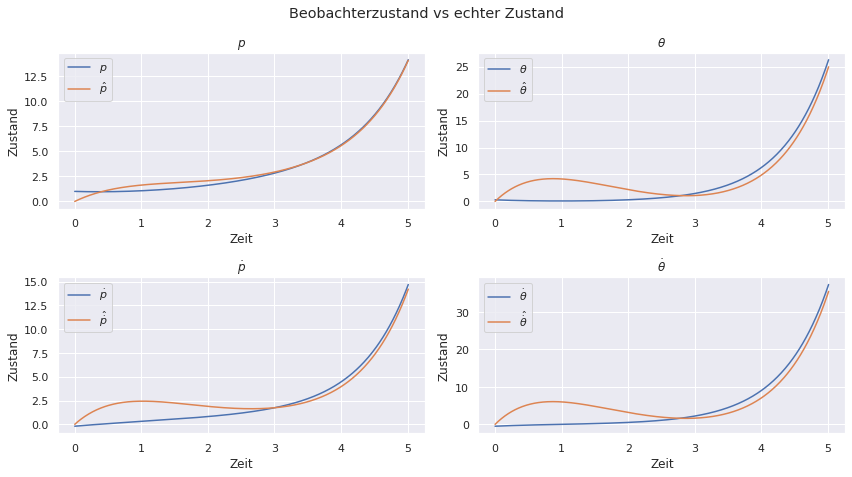

In [72]:
states, observer_states = simulate_observer(np.array([1, .3, -.2, -.5]), np.array([0, 0, 0, 0]), 5, u=.4, k=-0.8)
visualize_observer_states(states, observer_states)

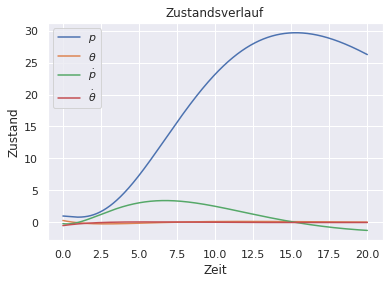

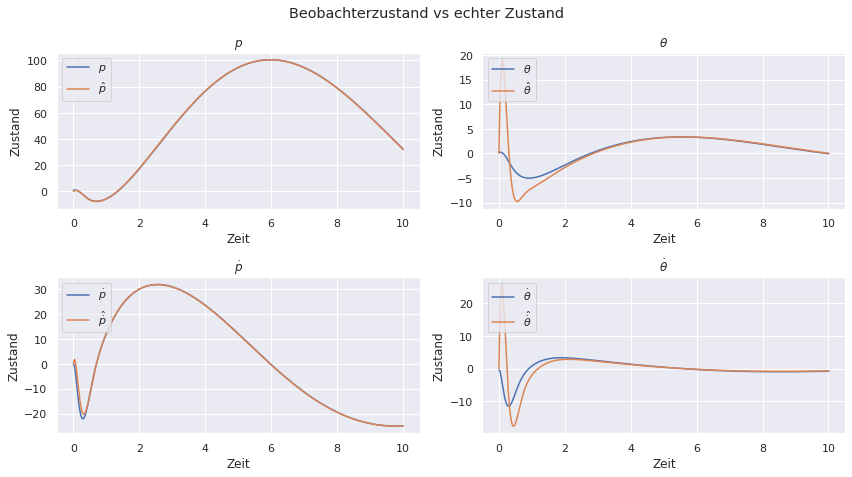

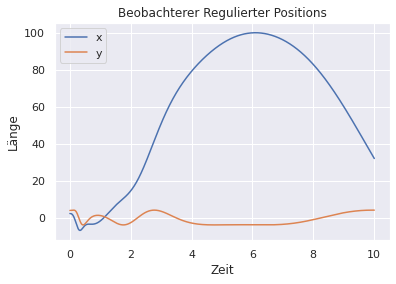

In [73]:
def regulator_for_k(k=-1):
    K = np.array(
        [[-(k ** 4) / 1.65, 12 * (k ** 2) + (2 / 1.65) * k ** 4 + 4, 4 * (k ** 3) / 1.65,
          -8 * k - (8 / 1.65) * k ** 3]])

    def regulator(state):
        return -K @ state

    return regulator


regulator = regulator_for_k(k=-.2)

states = simulate_states(np.array([1, .3, -.2, -.5]), 20, u=regulator)
visualize_states(states)

states, observer_states = simulate_observer(np.array([1, .3, -0.2, -0.5]), np.array([0, 0, 0, 0]), 10, u=regulator,
                                            k=-4)
visualize_observer_states(states, observer_states)
visualize_positions(calculate_positions(states), title="Beobachterer Regulierter Positions")
animate_joint_positions(calculate_joint_positions(states), title="Beobachterer Regulierter Positions")

In [74]:
def find_best_ks(reg_lim, obs_lim, obs_pieces=10, reg_pieces=10):
    obs_delta = (obs_lim[1] - obs_lim[0]) / obs_pieces
    reg_delta = (reg_lim[1] - reg_lim[0]) / reg_pieces

    best_reg_k = reg_lim[0]
    smalles_max = np.inf
    for reg_k in np.arange(reg_lim[0], reg_lim[1], reg_delta):
        for obs_k in np.arange(obs_lim[0], obs_lim[1], obs_delta):
            states, observer_states = simulate_observer(np.array([1, .3, -.2, -.5]), np.array([0, 0, 0, 0]), 100,
                                                        u=regulator_for_k(k=reg_k), k=obs_k)
            max = np.max(np.abs(np.array(list(states.values()))[:, 1]))

            if (max < smalles_max):
                smalles_max = max
                best_reg_k = reg_k

    best_obs_k = obs_lim[0]
    smalles_max = np.inf
    for obs_k in np.arange(obs_lim[0], obs_lim[1], obs_delta):
        states, observer_states = simulate_observer(np.array([1, .3, -.2, -.5]), np.array([0, 0, 0, 0]), 100,
                                                    u=regulator_for_k(k=best_reg_k), k=obs_k)

        max = np.max(np.abs(np.array(list(states.values()))[:, 1]))

        if (max < smalles_max):
            smalles_max = max
            best_obs_k = obs_k

    print(smalles_max)

    return (best_reg_k, best_obs_k)


print(find_best_ks((-.25, -.20), (-3, -2)))

5.578158475170916
(-0.20499999999999996, -3.0)
